<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/nlp/TransformersImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [0]:
!wget http://www.manythings.org/anki/spa-eng.zip

In [0]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

In [0]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import Dropout, LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm

In [0]:
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])

In [5]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))
    # add start & end tokens
    lines[col] = lines[col].apply(lambda x : '<START> '+ x + ' <END>')

In [0]:
pd.set_option('display.max_colwidth', 100)

## Creating Vocabulary
Create vocabulary of english and spanish words

In [9]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13477


In [10]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [11]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 49


In [12]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 49


In [14]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13477, 27264)

## Tokenization

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [17]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

<END> 1
<START> 2
a 3
aardvark 4
aardvarks 5
aaron 6
aback 7
abandon 8
abandoned 9
abandoning 10


In [18]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

<END> 1
<START> 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [20]:
lines = shuffle(lines)
lines.head()

,english,spanish
25772,<START> look forward please <END>,<START> mire al frente por favor <END>
28650,<START> i am tired of my work <END>,<START> estoy cansado de mi trabajo <END>
97189,<START> lets hope the weather is good tomorrow <END>,<START> esperemos que haga buen clima mañana <END>
115583,<START> why dont we see if tom wants to play cards with us <END>,<START> ¿por qué no vemos si tom quiere jugar cartas con nosotras <END>
96712,<START> i go home after everyone else goes home <END>,<START> me voy a casa después de que todos los demás se vayan a casa <END>


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train.shape, y_train.shape

((99016,), (99016,))

In [24]:
X_test.shape, y_test.shape

((24754,), (24754,))

## Positional Encoding

In [0]:
def positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))

    for pos in range(max_len):
        for i in range(0, d_model, 2):
            angle = pos / (np.power(10000, i/d_model))
            pos_enc[pos][i] = np.sin(angle)

            pos_enc[pos][i+1] = np.cos(angle)
    return pos_enc

## Masking

In [0]:
def get_masked_padding(x):
    x = x==0
    x = x[:, np.newaxis, np.newaxis, :]
    return tf.cast(x, tf.float32)

In [0]:
def get_lookahead_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = tf.cast(subsequent_mask, tf.int32)
    subsequent_mask = subsequent_mask == 0
    return tf.cast(subsequent_mask, tf.float32)

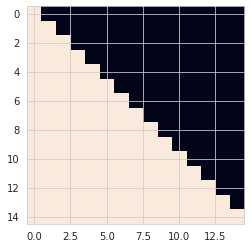

In [28]:
plt.figure(figsize=(4,4))
plt.imshow(get_lookahead_mask(15)[0])

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = get_masked_padding(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = get_masked_padding(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the decoder input
  look_ahead_mask = get_lookahead_mask(tar.shape[1])
  dec_target_padding_mask = get_masked_padding(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

## SingleHead Attention

In [0]:
def SingleHeadAttention(query, key, value, mask=None):
    """
    query - (batch_size, query_len, embedding_size)
    key - (batch_size, value_len, embedding_size)
    value - (batch_size, value_len, embedding_size)
    """
    
    # Step 1 - Matrix multiplication between query and key
    # weights --> (batch_size, query_len, value_len)
    weights = tf.matmul(query, key, transpose_b=True)

    # Step 2 - Weights Normalization
    # weights --> (batch_size, query_len, value_len)
    dim = key.shape[-1]
    weights = weights/np.sqrt(dim)
    
    if mask is not None:
        weights += (mask*-1e9) 

    # Step 3 - Softmax scores
    # weights --> (batch_size, query_len, value_len)
    weights = tf.nn.softmax(weights, axis=-1)
    
    # Step 4 - Context Vector
    # context --> (batch_size, query_len, embedding_size)
    context = tf.matmul(weights, value)
    
    return weights, context

## MutliHead Attention

In [0]:
def MultiHeadAttention(num_heads, d_model, query, key, value, mask):
    # Step 1 - Create 4 matrix Wq, Wk, Wv
    # creates a kernel of size [embedding_size, d_model]
    Wq = Dense(d_model)
    Wk = Dense(d_model)
    Wv = Dense(d_model)
    Wo = Dense(d_model)
    
    # Step 2 - Perform linear transformation
    # query --> (batch_size, query_len, d_model)
    query = Wq(query)
    # key --> (batch_size, value_len, d_model)
    key = Wk(key)
    # value --> (batch_size, value_len, d_model)
    value = Wv(value)
    
    # Step 3 - Reshape query,key and value. Transform 3D matrix to 4D matrix by breaking along the last axis & then transpose.
    assert d_model % num_heads == 0
    depth = d_model//num_heads
    # query --> (batch_size, query_len, num_heads, depth)
    query = tf.reshape(query, (query.shape[0], query.shape[1], num_heads, depth))
    # query --> (batch_size, num_heads, query_len, depth)
    query = tf.transpose(query, (0, 2, 1, 3))

    # key --> (batch_size, value_len, num_heads, depth)    
    key = tf.reshape(key, (key.shape[0], key.shape[1], num_heads, depth))
    # key --> (batch_size, num_heads, query_len, depth)
    key = tf.transpose(key, (0, 2, 1, 3))

    # value --> (batch_size, value_len, num_heads, depth)
    value = tf.reshape(value, (value.shape[0], value.shape[1], num_heads, depth))
    # value --> (batch_size, num_heads, query_len, depth)
    value = tf.transpose(value, (0, 2, 1, 3))
    
    # Step 4 - Apply ScaledDotProduct (SingleHeadAttention) on each of the heads
    attention_weights, context_vector = SingleHeadAttention(query, key, value, mask)
    # context_vector --> (batch_size, query_len, num_heads, depth)
    context_vector = tf.transpose(context_vector, (0, 2, 1, 3))
    
    # Step 5 - Concatenate along the `num_heads` axis
    # context_vector --> (batch_size, query_len, d_model)    
    context_vector = tf.reshape(context_vector, 
                                (context_vector.shape[0], context_vector.shape[1], d_model))
    
    # Step 6 - Apply linear transformation by multiplication with Wo
    context_vector = Wo(context_vector)
    return attention_weights, context_vector

## PointWise FeedForward Network

In [0]:
def point_wise_feed_forward_network(d_model, dff, x):
    dense1 = Dense(dff, activation='relu')
    dense2 = Dense(d_model)
    
    out = dense1(x)
    out = dense2(out)
    return out

## Encoder Layer

In [0]:
def single_encoder(num_heads, d_model, dff, query, key, value, mask):
    # Step 1 - MultiHeadAttention
    weights, context_vector = MultiHeadAttention(num_heads, d_model, 
                                                 query, key, value, mask)
    
    # Dropout
    dropout1 = Dropout(0.1)
    context_vector = dropout1(context_vector)
    
    # Step 2 - Normalize (x+attention(x))
    layer_norm1 = LayerNormalization()
    context_vector = layer_norm1(query+context_vector)
    
    # Step 3 - Pointwise FeedForward Network
    ffn_out = point_wise_feed_forward_network(d_model, dff, context_vector)
    
    # Dropout
    dropout2 = Dropout(0.1)
    ffn_out = dropout2(ffn_out)
    
    # Step 4 - Normalization again
    layer_norm2 = LayerNormalization()
    encoder_out = layer_norm1(context_vector+ffn_out)
    
    return encoder_out


## Encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               max_len, rate=0.1):
        super(Encoder, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        self.dff = dff
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        self.pos_encoding = self.pos_encoding[np.newaxis, ...]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = x.shape[1]

        x = self.embedding(x)
        x *= np.sqrt(self.d_model)
        # embedding+pos_encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = single_encoder(self.num_heads, self.d_model, self.dff, x, x, x, mask)

        return x

## Decoder Layer

In [0]:
def single_decoder(num_heads, d_model, dff, query, key, value, 
            encoder_out, look_ahead_mask, padding_mask):
    # Step 1 - MultiHeadAttention
    weights1, context_vector1 = MultiHeadAttention(num_heads, d_model, 
                                                 query, key, value, 
                                                 look_ahead_mask)
    
    # First Dropout
    dropout1 = Dropout(0.1)
    context_vector1 = dropout1(context_vector1)
    
    # Step 2 - Normalize (x+mha_attention1(x))
    layer_norm1 = LayerNormalization()
    context_vector1 = layer_norm1(query+context_vector1)

    # Step 3 - MultiHeadAttention. Here, the encoder_output is the Key & Value, 
    # while the ContextVector from previous MultiHeadAttention is Query
    weights2, context_vector2 = MultiHeadAttention(num_heads, d_model, 
                                                 context_vector1, encoder_out, encoder_out, 
                                                 padding_mask)
    
    # Second Dropout
    dropout2 = Dropout(0.1)
    context_vector2 = dropout2(context_vector2)
    
    # Step 4 - Normalize(mha_attention1(x)+mha_attention2(mha_attention1(x), encoder_output))
    layer_norm2 = LayerNormalization()
    context_vector2 = layer_norm2(context_vector1+context_vector2)

    # Step 5 - Pointwise FeedForward Network
    ffn_out = point_wise_feed_forward_network(d_model, dff, context_vector2)
    
    # Third Dropout
    dropout3 = Dropout(0.1)
    ffn_out = dropout3(ffn_out)
    
    # Step 4 - Normalization again
    layer_norm3 = LayerNormalization()
    decoder_out = layer_norm3(context_vector2+ffn_out)
    
    return decoder_out


## Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               max_len, rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        self.pos_encoding = self.pos_encoding[np.newaxis, ...]
        self.dropout = tf.keras.layers.Dropout(rate)

        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = x.shape[1]

        x = self.embedding(x)
        x *= np.sqrt(self.d_model)
        # embedding+pos_encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = single_decoder(self.num_heads, self.d_model, self.dff, x, x, x, 
                               enc_output, look_ahead_mask, padding_mask)
           
        return x


## Transformer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, num_encoder_tokens, num_decoder_tokens,
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, num_encoder_tokens, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, num_decoder_tokens, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):
    
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)  

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)

        return final_output


In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

# <START> & <END> token
input_vocab_size = num_encoder_tokens + 2
target_vocab_size = num_decoder_tokens + 2
dropout_rate = 0.1

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          num_encoder_tokens, 
                          num_decoder_tokens,
                          rate=dropout_rate)

## Data Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Returns a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    # encoder input seq
                    encoder_input_data[i, t] = input_token_index[word]
                target_words = target_text.split()
                for t, word in enumerate(target_words[:-1]):
                    # decoder input seq
                    decoder_input_data[i, t] = target_token_index[word] 
                for t, word in enumerate(target_words[1:]):
                    # decoder output seq
                    decoder_target_data[i, t] = target_token_index[word] 
            return (encoder_input_data, decoder_input_data, decoder_target_data)

## Loss & Optimizer

In [0]:
crossentropy = SparseCategoricalCrossentropy(from_logits=True)
def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [0]:
def train_func(targets, predictions):
    acc_func = SparseCategoricalAccuracy()
    acc = acc_func(targets, predictions)
    return acc

In [0]:
optimizer = tf.keras.optimizers.Adam()

## Training

In [0]:
EPOCHS = 20
BATCH_SIZE = 256

In [0]:
encoder_input_data, decoder_input_data, decoder_target_data = generate_batch(X_train, y_train, len(X_train))

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, 
                                             decoder_input_data, 
                                             decoder_target_data))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

In [0]:
@tf.function
def train_step(src_seq, tar_seq_in, tar_seq_out):
    enc_inp_mask, combined_mask, dec_inp_mask = create_masks(src_seq, 
                                                             tar_seq_in)

    with tf.GradientTape() as tape:
        predictions = transformer(src_seq, tar_seq_in, 
                                 True, 
                                 enc_inp_mask, 
                                 combined_mask, 
                                 dec_inp_mask)
        loss = loss_func(tar_seq_out, predictions)
        acc = train_func(tar_seq_out, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    return loss, acc

In [0]:
for epoch in range(EPOCHS):
    for batch, (src_seq, tar_seq_in, tar_seq_out) in tqdm(enumerate(dataset.take(-1))):
        loss, acc = train_step(src_seq, tar_seq_in, tar_seq_out)
    print (f'Epoch {epoch} Loss {loss:.4f} Accuracy {acc:.4f}')


Epoch 0 Loss 1.4518 Accuracy 0.0000



Epoch 1 Loss 1.2727 Accuracy 0.0019



Epoch 2 Loss 1.1818 Accuracy 0.0005



Epoch 3 Loss 1.0293 Accuracy 0.0114
